# Reinforcement Learning

# 6. Bandit Algorithms

This notebook presents **multi-armed bandit** algorithms.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

from utils.model import Environment
from utils.agent import Agent

## Multi-Armed Bandit

Multi-armed bandits are single-state models with random rewards.

In [2]:
class MAB(Environment):
    """Multi-Armed Bandit environnement.
    
    Parameters
    ----------
    distribution: string
        Reward distribution (Bernoulli, Uniform or Gaussian)
    params: list
        List of parameters (one per action)
        Example for Bernoulli (mean): [0.4, 0.5, 0.6]
        Example for Uniform (low, high): [(-1, 1), (0, 1), (-1, 2)]
        Example for Gaussian (mean, variance): [(0, 1), (1, 2), (-1, 1)]
    """

    def __init__(self, distribution: str='bernoulli', params=None):
        super(MAB, self).__init__()
        if params is None:
            params = [0.4, 0.6]
        if type(distribution) != str:
            raise ValueError("The parameter 'distribution' must be a string: either 'bernoulli', 'uniform' or 'gaussian'.")
        self.distribution = distribution.lower()
        self.params = params
         
    @staticmethod
    def get_states():
        """Single state."""
        return [None]
    
    def get_actions(self):
        """One action per arm."""
        actions = [action for action, _ in enumerate(self.params)]
        return actions
    
    def get_reward(self, action):
        """Random reward. The parameter depends on the action."""
        if self.distribution == 'bernoulli':
            return np.random.random() < self.params[action]
        if self.distribution == 'uniform':
            low, high = self.params[action]
            return np.random.uniform(low, high)
        if self.distribution in ['gaussian', 'normal']:
            mean, std = self.params[action]
            return np.random.normal(mean, std)
        raise ValueError('Unknown distribution.')

    def get_model(self):
        raise ValueError('Not available.')
        
    def step(self, action):
        stop = False
        reward = self.get_reward(action)
        return reward, stop

In [3]:
class Bandit(Agent):
    """Bandit algorithm with random policy. 

    Parameters
    ----------
    model : object of class MAB
        The model.
    init_value : float
        Initial value of the action-value function.
    init_count : int
        Initial count of the action-count function.
    """
    
    def __init__(self, model: MAB, init_value: float=0, init_count: int=0):
        super(Bandit, self).__init__(model)
        if not isinstance(model, MAB):
            raise ValueError('The model must be a multi-armed bandit.')
        self.model = model
        self.policy = self.random_policy
        actions = model.get_actions()
        self.values = len(actions) * [init_value]
        self.counts = len(actions) * [init_count]

    def get_actions(self, state=None):
        """Get all possible actions."""
        return self.model.get_actions()
    
    def get_episode(self, horizon=100):
        """Get the rewards for an episode and update the values."""
        state = None
        rewards = []
        for t in range(horizon):
            action = self.get_action(state)
            reward, _ = self.model.step(action)
            rewards.append(reward)
            self.counts[action] += 1
            diff = reward - self.values[action]
            # update by temporal difference
            self.values[action] += diff / self.counts[action]
        return rewards

In [4]:
print("-"*5, " Model ", "-"*5)
model = MAB()
print(f"Model distribution: {model.distribution}")
print(f"Model parameters: {model.params}")
print(f"Actions: {model.get_actions()}")

print("-"*5, " Bandit Agent ", "-"*5)
agent = Bandit(model)
rewards = agent.get_episode(horizon=100)
print(f"Mean of rewards: {np.mean(rewards):.2f}")
print(f"Values: {agent.values}")
print(f"Counts: {agent.counts}")

-----  Model  -----
Model distribution: bernoulli
Model parameters: [0.4, 0.6]
Actions: [0, 1]
-----  Bandit Agent  -----
Mean of rewards: 0.51
Values: [0.4150943396226415, 0.6170212765957448]
Counts: [53, 47]


## The $\varepsilon$-greedy policy

In [5]:
class Greedy(Bandit):
    """Bandit algorithm with epsilon-greedy policy. 

    Parameters
    ----------
    model : object of class MAB
        The model.
    epsilon : float in [0, 1]
        Exploration rate.
    init_value : float
        Initial value of the action-value function.
    init_count : int
        Initial count of the action-count function.
    """
    
    def __init__(self, model: MAB, epsilon: float=0.1, init_value: float=0, init_count: int=0):
        super(Greedy, self).__init__(model, init_value, init_count) 
        self.epsilon = epsilon

    def get_action(self, state=None):
        """Get action with eps-greedy policy."""
        actions = self.get_actions()
        if np.random.random() > self.epsilon:
            # select the best action(s) with probability 1 - epsilon
            values = np.array(self.values)
            actions = np.flatnonzero(values==np.max(values))
        return np.random.choice(actions)


In [6]:
print("-"*5, " Greedy Bandit Agent ", "-"*5)
agent = Greedy(model)
rewards = agent.get_episode(horizon=100)
print(f"Mean of rewards: {np.mean(rewards):.2f}")
print(f"Values: {agent.values}")
print(f"Counts: {agent.counts}")

-----  Greedy Bandit Agent  -----
Mean of rewards: 0.53
Values: [0.3, 0.5555555555555556]
Counts: [10, 90]


## To do 

* Compute the expected **gain** for $\varepsilon = 0.2$ and check your result by simulation.<br>**Hint:** You might adapt the time horizon.
* Observe the phenomenon of **optimism in face of incertainty** when $\varepsilon = 0$.<br>**Hint:** You might adapt the parameters ``init_value`` and ``init_count``.

In [7]:
# Compute the expected gain for epsilon = 0.2
print("-"*5, " Expectation, epsilon=0.2 ", "-"*5)
epsilon = 0.2
values = np.array(model.params)
actions = model.get_actions()
best_actions = np.flatnonzero(values==np.max(values))
probs = np.ones(len(actions)) * epsilon / len(actions)
probs[best_actions] += 1 - epsilon
gain = np.sum(values * probs)
print(f"Expected gain: {gain:.2f}")

# Simulate the expected gain for epsilon = 0.2
print("\n" + "-"*5, " Simulation, epsilon=0.2 ", "-"*5)
n_simulations = 100
horizon = 1000
rewards = np.zeros((n_simulations, horizon))
for simulation in tqdm(range(n_simulations), desc="Simulating ..."):
    agent = Greedy(model, epsilon=0.2)
    rewards[simulation] = agent.get_episode(horizon=horizon)
print(f"Mean of rewards: {np.mean(rewards):.2f}")

-----  Expectation, epsilon=0.2  -----
Expected gain: 0.58

-----  Simulation, epsilon=0.2  -----


Simulating ...:   0%|          | 0/100 [00:00<?, ?it/s]

Mean of rewards: 0.58


In [8]:
# Optimism in face of incertainty
print("-"*5, " Optimism, epsilon=0 ", "-"*5)
agent = Greedy(model, epsilon=0., init_value=1., init_count=1)
rewards = agent.get_episode(horizon=1000)
print(f"Mean of rewards: {np.mean(rewards):.2f}")
print(f"Values: {agent.values}")
print(f"Counts: {agent.counts}")

-----  Optimism, epsilon=0  -----
Mean of rewards: 0.61
Values: [0.5, 0.6120000000000001]
Counts: [2, 1000]


## The UCB policy

We now consider the UCB (Upper Confidence Bound) policy.

## To do

* Complete and test the agent ``UCB`` below.
* Plot the **regret** with respect to the time horizon, and compare with the $\varepsilon$-greedy policy for different values of $\varepsilon$.
* Repeat this experiment for the other models (uniform and Gaussian).<br> Interpret the results.
* Test the impact of the number of actions.

In [9]:
class UCB(Bandit):
    """Bandit algorithm with UCB policy. 

    Parameters
    ----------
    model : object of class MAB
        The model.
    const : float in [0, 1]
        Multiplicative constant for the UCB bonus.
    init_value : float
        Initial value of the action-value function.
    init_count : int
        Initial count of the action-count function.
    """
    
    def __init__(self, model: MAB, const: float=1, init_value: float=0, init_count: int=0):
        super(UCB, self).__init__(model, init_value, init_count) 
        self.const = const

    def get_action(self, state=None):
        """Get action with UCB policy."""
        values = np.array(self.values)
        counts = np.array(self.counts)
        actions = self.get_actions()

        total_counts = np.sum(counts)
        if total_counts == 0:
            # If no actions have been taken yet, randomly select an action
            return np.random.choice(actions)

        # UCB calculation
        ucb = values + self.const * np.sqrt(np.log(total_counts + 1) / (counts + 1e-5))
        best_actions = np.flatnonzero(ucb == np.max(ucb))
        best_action = np.random.choice(best_actions) # In case of multiple best actions

        return best_action


In [10]:
# Test the UCB agent
print("-"*5, " UCB Bandit Agent ", "-"*5)
n_simulations = 100
horizon = 1000
rewards = np.zeros((n_simulations, horizon))
for simulation in tqdm(range(n_simulations), desc="Simulating ..."):
    agent = UCB(model)
    rewards[simulation] = agent.get_episode(horizon=horizon)
print(f"Mean of rewards: {np.mean(rewards):.2f}")

-----  UCB Bandit Agent  -----


Simulating ...:   0%|          | 0/100 [00:00<?, ?it/s]

Mean of rewards: 0.58


## Thompson sampling

Finally, we consider Thompson Sampling, where the mean rewards are considered as random and sampled according to the posterior distribution (Bayesian algorithm).

## To do

* Complete and test the agent ``TS`` below.
* Plot the **regret** with respect to the time horizon, and compare with the UCB policy for different models.
* Which algorithm is the more efficient?<br> Comment your results.

In [11]:
class TS(Bandit):
    """Bandit algorithm with Thompson sampling. 

    Parameters
    ----------
    model : object of class MAB
        The model.
    """
    
    def __init__(self, model):
        super(TS, self).__init__(model) 
        self.distribution = model.distribution
            
    def get_action(self, state=None):
        """Get action with TS policy."""
        values = np.array(self.values)
        counts = np.array(self.counts)
        if self.distribution == 'bernoulli':
            # Beta distribution for Bernoulli rewards
            alpha = values * counts + 1 # successes
            beta = (1 - values) * counts + 1 # failures
            samples = np.random.beta(alpha, beta)
        elif self.distribution == 'uniform':
            # Uniform distribution for Uniform rewards
            low, high = np.array(self.model.params).T
            samples = np.random.uniform(low, high)
        elif self.distribution == 'gaussian':
            # Normal distribution for Gaussian rewards
            mean = values
            std = np.sqrt(1 / (counts + 1e-5))
            samples = np.random.normal(mean, std)
        else:
            raise ValueError(f"Unknown distribution: {self.distribution}. Please use 'bernoulli', 'uniform' or 'gaussian' for Thomson sampling.")
        return np.argmax(samples)


In [12]:
# Test the TS agent
print("-"*5, " TS Bandit Agent ", "-"*5)
n_simulations = 100
horizon = 1000
rewards = np.zeros((n_simulations, horizon))
for simulation in tqdm(range(n_simulations), desc="Simulating ..."):
    agent = TS(model)
    rewards[simulation] = agent.get_episode(horizon=horizon)
print(f"Mean of rewards: {np.mean(rewards):.2f}")

-----  TS Bandit Agent  -----


Simulating ...:   0%|          | 0/100 [00:00<?, ?it/s]

Mean of rewards: 0.59


Computing regrets ...:   0%|          | 0/3 [00:00<?, ?it/s]

Simulating UCB with bernoulli ...:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating UCB with uniform ...:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating UCB with gaussian ...:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Greedy with bernoulli ...:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Greedy with bernoulli ...:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Greedy with bernoulli ...:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Greedy with uniform ...:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Greedy with uniform ...:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Greedy with uniform ...:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Greedy with gaussian ...:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Greedy with gaussian ...:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Greedy with gaussian ...:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating TS with bernoulli ...:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating TS with uniform ...:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating TS with gaussian ...:   0%|          | 0/100 [00:00<?, ?it/s]

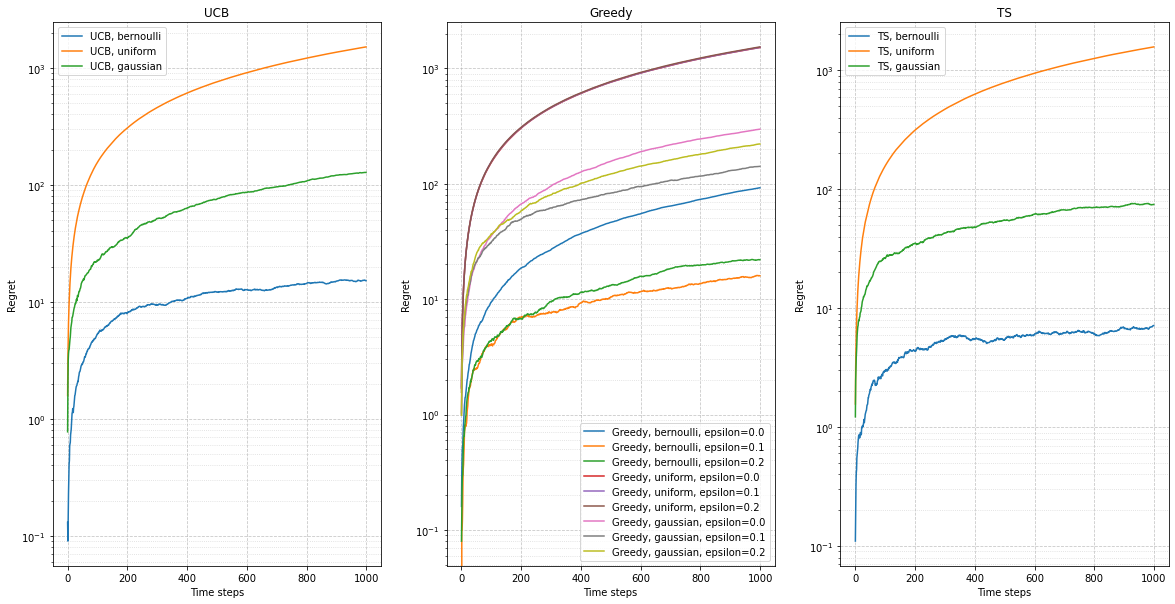

,Agent,Model,Params,Final Regret
12,TS,bernoulli,N/A,7.140000
0,UCB,bernoulli,N/A,15.190000
4,Greedy,bernoulli,epsilon=0.1,15.940000
5,Greedy,bernoulli,epsilon=0.2,21.960000
14,TS,gaussian,N/A,74.526431
3,Greedy,bernoulli,epsilon=0.0,92.270000
2,UCB,gaussian,N/A,127.858072
10,Greedy,gaussian,epsilon=0.1,141.444794
11,Greedy,gaussian,epsilon=0.2,221.087862
9,Greedy,gaussian,epsilon=0.0,297.005341


In [13]:
# Define the parameters
DISABLE_TQDM = False
n_simulations = 100
horizon = 1000
epsilons = [0., 0.1, 0.2]
const = 1
agents = [UCB, Greedy, TS]
n_models = 3
models = [
    MAB('bernoulli'),
    MAB('uniform', params=[(-1, 1), (0, 1), (-1, 2)]),
    MAB('gaussian', params=[(0, 1), (1, 2), (-1, 1)])
]

# Function to calculate regrets
def calculate_regrets(agent_class, model, epsilon=None, const=None, disable=False):
    regrets = np.zeros((n_simulations, horizon))

    # Calculate the expected reward of the optimal action
    if model.distribution == 'bernoulli':
        optimal_reward = np.max(model.params)
    elif model.distribution == 'uniform':
        optimal_reward = np.max([high for _, high in model.params])
    elif model.distribution in ['gaussian', 'normal']:
        optimal_reward = np.max([mean for mean, _ in model.params])
    else:
        raise ValueError("Unsupported distribution")

    # Cumulative reward of the optimal policy over the horizon
    optimal_cumulative_reward = np.cumsum([optimal_reward] * horizon)

    for simulation in tqdm(range(n_simulations), desc=f"Simulating {agent_class.__name__} with {model.distribution} ...", disable=disable):
        if agent_class == Greedy:
            agent = agent_class(model, epsilon=epsilon)
        elif agent_class == UCB:
            agent = agent_class(model, const=const)
        else:
            agent = agent_class(model)
        rewards = agent.get_episode(horizon=horizon)
        cumulative_rewards = np.cumsum(rewards)
        regrets[simulation] = optimal_cumulative_reward - cumulative_rewards
    return regrets

regrets={}

# Plotting regrets for each agent
fig, axs = plt.subplots(1, len(agents), figsize=(20, 10))
for i, Agent in tqdm(enumerate(agents), desc=f"Computing regrets ...", total=len(agents), disable=DISABLE_TQDM):
    regrets_agent = {}
    for model in models:
        if Agent == Greedy:
            regrets_epsilon = {}
            for epsilon in epsilons:
                regrets_epsilon[epsilon] = np.mean(calculate_regrets(Agent, model, epsilon=epsilon, disable=DISABLE_TQDM), axis=0)
                axs[i].plot(regrets_epsilon[epsilon], label=f"{Agent.__name__}, {model.distribution}, epsilon={epsilon}")
            regrets_agent[model.distribution] = regrets_epsilon
        else:
            regrets_agent[model.distribution] = np.mean(calculate_regrets(Agent, model, const=const, disable=DISABLE_TQDM), axis=0)
            axs[i].plot(regrets_agent[model.distribution], label=f"{Agent.__name__}, {model.distribution}")
    regrets[Agent.__name__] = regrets_agent
    # Formatting the plot
    axs[i].set_yscale('log')
    axs[i].grid(True, linestyle='--', alpha=0.7)
    axs[i].grid(True, which='minor', linestyle=':', alpha=0.5)
    axs[i].set_xlabel('Time steps')
    axs[i].set_ylabel('Regret')
    axs[i].set_title(f"{Agent.__name__}")
    axs[i].legend()
plt.show()

# Summarize the regrets into a structured table
regret_table = []
for agent_name, agent_data in regrets.items():
    for model_name, model_data in agent_data.items():
        if isinstance(model_data, dict):  # For Greedy with multiple epsilons
            for epsilon, regret in model_data.items():
                regret_table.append({
                    "Agent": agent_name,
                    "Model": model_name,
                    "Params": f"epsilon={epsilon}",
                    "Final Regret": regret[-1]  # Cumulative regret at the last time step
                })
        else:  # For UCB and TS
            regret_table.append({
                "Agent": agent_name,
                "Model": model_name,
                "Params": "N/A",
                "Final Regret": model_data[-1]  # Cumulative regret at the last time step
            })

# Create a pandas DataFrame for easier sorting and display
df_regrets = pd.DataFrame(regret_table)
df_regrets = df_regrets.sort_values(by="Final Regret", ascending=True)

# Display the DataFrame
display(df_regrets)

## Conclusion

The best model seems to be the TS Agent with Bernoulli distribution. It has the lowest regret compared to the other models. Others agents with bernoulli distribution also perform well. Agents with uniform distribution habe the highest regret.